# Iowa Prison Recidivism Analysis

Author: Robert Harrow

## Overview

Stakeholder: Iowa Department of Corrections
Business Questions:
1. What features can help predict recidivism?
2. What can the DoC do to reduce recidivism?

## Data Understanding & Preperation

### Importing Dataset

Dataset located at: https://mydata.iowa.gov/Correctional-System/3-Year-Recidivism-for-Offenders-Released-from-Pris/mw8r-vqy4

**Load Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score

import joblib

from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Dictionary

| Column Name                | Description                                                                                                                                                                                                          |
|:---------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Fiscal Year Released       | Fiscal year (year ending June 30) for which the offender was released from prison.                                                                                                                                   |
| Recidivism Reporting Year  | Fiscal year (year ending June 30) that marks the end of the 3-year tracking period. For example, offenders exited prison in FY 2012 are found in recidivism reporting year FY 2015.                                  |
| Main Supervising District  | The Judicial District supervising the offender for the longest time during the tracking period.                                                                                                                      |
| Release Type               | Reasoning for Offender's release from prison.                                                                                                                                                                        |
| Race - Ethnicity           | Offender's Race and Ethnicity                                                                                                                                                                                        |
| Age At Release             | Offender's age group at release from prison.                                                                                                                                                                         |
| Sex                        | Gender of our offender                                                                                                                                                                                               |
| Offense Classification     | Maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days                 |
| Offense Type               | General category for the most serious offense for which the offender was placed in prison.                                                                                                                           |
| Offense Subtype            | Further classification of the most serious offense for which the offender was placed in prison.                                                                                                                      |
| Return to Prison           | No = Did not return to prison within the three year tracking period; Yes = Admitted to prison for any reason within the three year tracking period                                                                   |
| Days to Return             | Number of days it took before the offender returned to prison.                                                                                                                                                       |
| Recidivism Type            | Indicates the reason for return to prison.                                                                                                                                                                           |
| New Offense Classification | New conviction maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days  |
| New Offense Type           | General category for the new conviction while the offender is out of prison.                                                                                                                                         |
| New Offense Sub Type       | Further classification of the new conviction.                                                                                                                                                                        |
| Target Population          | The Department of Corrections has undertaken specific strategies to reduce recidivism rates for prisoners who are on parole.                                                                                         |


In [2]:
prisoner_df = pd.read_csv('data/recidivism.csv')

In [3]:
# Preview first 5 rows
prisoner_df.head()

,Fiscal Year Released,Recidivism Reporting Year,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Return to Prison,Days to Return,Recidivism Type,New Offense Classification,New Offense Type,New Offense Sub Type,Target Population
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,433.0,New,C Felony,Drug,Trafficking,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,453.0,Tech,NaN,NaN,NaN,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,832.0,Tech,NaN,NaN,NaN,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,116.0,Tech,NaN,NaN,NaN,No


In [4]:
# Get overview of the data
prisoner_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020 entries, 0 to 26019
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Fiscal Year Released        26020 non-null  int64  
 1   Recidivism Reporting Year   26020 non-null  int64  
 2   Main Supervising District   16439 non-null  object 
 3   Release Type                24258 non-null  object 
 4   Race - Ethnicity            25990 non-null  object 
 5   Age At Release              26017 non-null  object 
 6   Sex                         26017 non-null  object 
 7   Offense Classification      26020 non-null  object 
 8   Offense Type                26020 non-null  object 
 9   Offense Subtype             26020 non-null  object 
 10  Return to Prison            26020 non-null  object 
 11  Days to Return              8681 non-null   float64
 12  Recidivism Type             26020 non-null  object 
 13  New Offense Classification  671

In [5]:
# Explore distribution of target

prisoner_df['Return to Prison'].value_counts()

No     17339
Yes     8681
Name: Return to Prison, dtype: int64

In [6]:
prisoner_df['Recidivism Type'].value_counts()

No Recidivism    17339
New               5516
Tech              3165
Name: Recidivism Type, dtype: int64

In [7]:
# Exploring proportion of missing data
prisoner_df.isna().mean()

Fiscal Year Released          0.000000
Recidivism Reporting Year     0.000000
Main Supervising District     0.368217
Release Type                  0.067717
Race - Ethnicity              0.001153
Age At Release                0.000115
Sex                           0.000115
Offense Classification        0.000000
Offense Type                  0.000000
Offense Subtype               0.000000
Return to Prison              0.000000
Days to Return                0.666372
Recidivism Type               0.000000
New Offense Classification    0.741814
New Offense Type              0.741814
New Offense Sub Type          0.742544
Target Population             0.000000
dtype: float64

### Basic Data Cleaning

Data is missing for the following columns:
* **Main Supervising District.** Based on an email I received from the Iowa Department of Corrections <em>"When a Main Supervising District is blank, this means they discharged straight from prison and were not supervised by Community Based Corrections."</em>
* **Release Type/Race - Ethnicity/Age At Release/Sex.** Just 0.01% - 6% of data is missing here. I will likely just drop these records.
* **Days to Return/New Offense Classification/New Offense Type/New Offense Sub Type.** It makes sense for this data to be missing since we have records of people who never returned to prison. Also, we don't need these columns for modeling.

In [8]:
# Replacing Main Supervising District NaN with 'None'
prisoner_df['Main Supervising District'] = prisoner_df['Main Supervising District'].fillna('None')

In [9]:
# Dealing with records with small amounts of missing values
prisoner_df.dropna(subset=['Release Type', 'Race - Ethnicity','Age At Release ','Sex'], inplace=True)

In [10]:
# Dropping columns not needed for modeling
cols_to_drop = ['Fiscal Year Released',
                'Recidivism Reporting Year',
                'Days to Return',
                'Recidivism Type',
                'New Offense Classification',
                'New Offense Type',
                'New Offense Sub Type',
                'Offense Subtype' # dropping this for now because it gets too granural
               ]

In [11]:
prisoner_df_relevant = prisoner_df.drop(cols_to_drop, axis=1)

In [12]:
prisoner_df_relevant["Return to Prison"].replace({"Yes": 1, "No": 0}, inplace=True)

In [13]:
for col in prisoner_df_relevant.columns:
    print(prisoner_df_relevant[col].value_counts())

None                  7787
5JD                   4982
1JD                   2787
2JD                   1988
8JD                   1556
7JD                   1514
3JD                   1188
6JD                   1098
4JD                    666
ISC                    350
Interstate Compact     309
Name: Main Supervising District, dtype: int64
Parole                                 9810
Parole Granted                         5577
Discharged – End of Sentence           5007
Discharged - Expiration of Sentence    2335
Released to Special Sentence            401
Special Sentence                        347
Paroled w/Immediate Discharge           334
Paroled to Detainer - Out of State      137
Paroled to Detainer - INS               134
Paroled to Detainer - U.S. Marshall      77
Paroled to Detainer - Iowa               66
Name: Release Type, dtype: int64
White - Non-Hispanic                               16460
Black - Non-Hispanic                                5687
White - Hispanic          

In [14]:
# Dropping Race - Ethnicity group and Offense Subtype for which we don't have too much data for
prisoner_df_relevant = prisoner_df_relevant.groupby('Race - Ethnicity').filter(lambda x: len(x) > 100)

### Split data for cleaning & training

In [15]:
X = prisoner_df_relevant.drop(['Return to Prison'], axis=1)
y = prisoner_df_relevant['Return to Prison']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [16]:
def release_type_transformer(df):
    '''
    Create 3 bins to reduce release type to the three major types of prison releases
    '''
    df.loc[df['Release Type'].str.contains('parole', case=False), 'Release Type'] = 'parole'
    df.loc[df['Release Type'].str.contains('discharged', case=False), 'Release Type'] = 'discharged'
    df.loc[df['Release Type'].str.contains('special', case=False), 'Release Type'] = 'special sentence'
    return df

def offense_classification_transformer(df):
    '''
    Create 3 bins to reduce release type to the three major types of prison releases
    '''
    df.loc[df['Offense Classification'].str.contains('felony', case=False), 'Offense Classification'] = 'felony'
    df.loc[df['Offense Classification'].str.contains('misdemeanor', case=False), 'Offense Classification'] = 'misdemeanor'
    df.loc[df['Offense Classification'].str.contains('Special Sentence', case=False), 'Offense Classification'] = 'other'
    df.loc[df['Offense Classification'].str.contains('Sexual Predator', case=False), 'Offense Classification'] = 'other'
    return df

In [17]:
cleaning_pipeline = Pipeline(steps=[
    ('release', FunctionTransformer(release_type_transformer)),
    ('classification', FunctionTransformer(offense_classification_transformer))
])

In [18]:
X_train_clean = cleaning_pipeline.fit_transform(X_train)

In [19]:
X_train_clean

,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Target Population
17734,5JD,parole,White - Non-Hispanic,25-34,Male,felony,Public Order,No
15318,5JD,parole,White - Non-Hispanic,25-34,Male,felony,Drug,Yes
487,None,discharged,White - Non-Hispanic,Under 25,Male,felony,Violent,No
10967,5JD,parole,White - Non-Hispanic,35-44,Male,felony,Drug,Yes
2945,None,discharged,White - Non-Hispanic,Under 25,Male,felony,Property,No
...,...,...,...,...,...,...,...,...
10333,None,discharged,White - Non-Hispanic,45-54,Male,felony,Property,No
10647,1JD,parole,Black - Non-Hispanic,35-44,Male,felony,Drug,Yes
3538,6JD,parole,White - Non-Hispanic,25-34,Female,felony,Property,Yes
14715,6JD,parole,Asian or Pacific Islander - Non-Hispanic,Under 25,Male,felony,Property,Yes


In [20]:
# Test for multicolinearity
cols = list(X_train_clean.columns)
x_train_clean_ohe = pd.get_dummies(X_train_clean, prefix=cols, sparse=False, drop_first=True)
training_data = pd.concat([y_train, x_train_clean_ohe], axis=1)

In [21]:
training_data.columns = training_data.columns.str.replace(' ','_')
training_data

,Return_to_Prison,Main_Supervising_District_2JD,Main_Supervising_District_3JD,Main_Supervising_District_4JD,Main_Supervising_District_5JD,Main_Supervising_District_6JD,Main_Supervising_District_7JD,Main_Supervising_District_8JD,Main_Supervising_District_ISC,Main_Supervising_District_Interstate_Compact,...,Age_At_Release__55_and_Older,Age_At_Release__Under_25,Sex_Male,Offense_Classification_misdemeanor,Offense_Classification_other,Offense_Type_Other,Offense_Type_Property,Offense_Type_Public_Order,Offense_Type_Violent,Target_Population_Yes
17734,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
15318,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
487,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
10967,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2945,1,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10333,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
10647,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3538,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
14715,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,0,0,1,0,0,1


### Model Iterations

In [22]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    # we pass in pipe to cross validate along with a feature list.
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())

### Dummy classifier

In [23]:
dummy_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(drop='first', sparse=False)),
    ('dc', DummyClassifier(strategy='most_frequent'))])

In [24]:
dummy_pipe.fit(X_train_clean, y_train)

Pipeline(steps=[('ohe', OneHotEncoder(drop='first', sparse=False)),
                ('dc', DummyClassifier(strategy='most_frequent'))])

In [25]:
print_cv_scores(dummy_pipe, X_train_clean, y_train)

/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

[0.65587687 0.65587687 0.65590062 0.65583161 0.65583161]
Training Accuracy 0.6558635162697615
##############
[0.6558101  0.6558101  0.65571507 0.65599117 0.65599117]
Cross_Val Accuracy 0.6558635217998757
##############
Training Macro Precision: 0.32793175813488074
Cross_Val Macro Precision: 0.32793176089993786
##############
Training Macro Recall: 0.5
Cross_Val Macro Recall: 0.5
##############
Training Macro F1: 0.39608549228276707
Cross_Val Macro F1: 0.39608549180816954


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


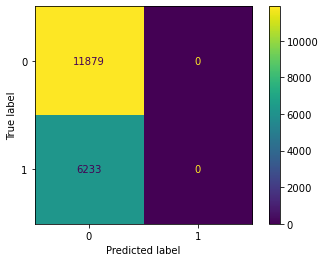

In [26]:
plot_confusion_matrix(dummy_pipe, X_train_clean, y_train)

### Logistic Regression classifier
#### With SMOTE

In [27]:
# lr_param_grid = {
#     'lr__penalty': ['none', 'l1'],
#     'lr__C': [0.01, 0.1, 1, 10, 1e5],
#     'lr__class_weight': [None, 'balanced'],
# }

# lr1_pipe = imbpipe(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('sm', SMOTE(random_state=42)),
#     ('lr', LogisticRegression(max_iter=1000, random_state=123))
# ])

# lr1_gridsearch = GridSearchCV(estimator=lr1_pipe, 
#                           param_grid=lr_param_grid, 
#                           scoring='recall', 
#                           cv=5)

# # Fit the training data
# lr1_gridsearch.fit(X_train_clean, y_train)

# # Pickling the model
# with open("models/lr1_gridsearch.pkl", "wb") as f:
#     joblib.dump(lr1_gridsearch, f)

/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none'

/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/robertharrow/o

In [28]:
# Reading the pickle file
with open('models/lr1_gridsearch.pkl', 'rb') as f:
    lr1_gridsearch = joblib.load(f)

In [29]:
print(lr1_gridsearch.best_params_)

{'lr__C': 0.01, 'lr__class_weight': None, 'lr__penalty': 'none'}


In [30]:
# # Logistic Regression with best params

# lr_pipe2 = imbpipe(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('sm', SMOTE(random_state=42)),
#     ('lr', LogisticRegression(max_iter=1000, class_weight= None, penalty= 'none', random_state=123))
# ])

# lr_pipe2.fit(X_train_clean, y_train)

# with open("models/lr_pipe2.pkl", "wb") as f:
#     joblib.dump(lr_pipe2, f)

In [31]:
# Reading the pickle file
with open('models/lr_pipe2.pkl', 'rb') as f:
    lr_pipe2 = joblib.load(f)

[0.60583891 0.60908275 0.60931677 0.60655625 0.60434783]
Training Accuracy 0.6070285013342265
##############
[0.60861165 0.60640353 0.59773606 0.60657096 0.61347322]
Cross_Val Accuracy 0.6065590825410939
##############
Training Macro Precision: 0.6119246628623471
Cross_Val Macro Precision: 0.6113469840898056
##############
Training Macro Recall: 0.6238478221304453
Cross_Val Macro Recall: 0.6231952005909339
##############
Training Macro F1: 0.5991087031661386
Cross_Val Macro F1: 0.5985727229083386


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


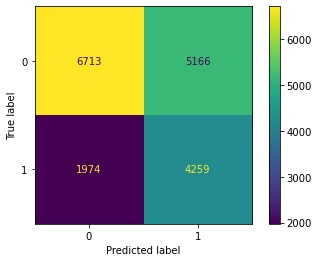

In [32]:
print_cv_scores(lr_pipe2, X_train_clean, y_train)
plot_confusion_matrix(lr_pipe2, X_train_clean, y_train)

### Logistic Regression Without SMOTE

In [33]:
# lr3_pipe = Pipeline(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('lr', LogisticRegression(max_iter=1000, random_state=123))
# ])

# lr3_gridsearch = GridSearchCV(estimator=lr3_pipe, 
#                           param_grid=lr_param_grid, 
#                           scoring='recall', 
#                           cv=5)

# # Fit the training data
# lr3_gridsearch.fit(X_train_clean, y_train)

# with open("models/lr3_gridsearch.pkl", "wb") as f:
#     joblib.dump(lr3_gridsearch, f)

/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none'

/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/robertharrow/opt/anaconda3/envs/learn-env

In [34]:
# Reading the pickle file
with open('models/lr3_gridsearch.pkl', 'rb') as f:
    lr3_gridsearch = joblib.load(f)

In [35]:
print(lr3_gridsearch.best_params_)

{'lr__C': 0.01, 'lr__class_weight': 'balanced', 'lr__penalty': 'none'}


In [36]:
# Logistic Regression with best params no SMOTE

# lr_pipe4 = Pipeline(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('lr', LogisticRegression(max_iter=1000, class_weight= 'balanced', penalty= 'none', random_state=123))
# ])

# lr_pipe4.fit(X_train_clean, y_train)

# with open("models/lr_pipe4.pkl", "wb") as f:
#     joblib.dump(lr_pipe4, f)

In [37]:
# Reading the pickle file
with open('models/lr_pipe4.pkl', 'rb') as f:
    lr_pipe4 = joblib.load(f)

[0.60218096 0.60715025 0.60828157 0.60628019 0.60655625]
Training Accuracy 0.6060898458415014
##############
[0.60281535 0.60226332 0.60187742 0.60684705 0.60960795]
Cross_Val Accuracy 0.6046822154244014
##############
Training Macro Precision: 0.6137305034493441
Cross_Val Macro Precision: 0.6119456741600103
##############
Training Macro Recall: 0.6256771996551194
Cross_Val Macro Recall: 0.6237084070774568
##############
Training Macro F1: 0.5990740332277956
Cross_Val Macro F1: 0.5974939667824017


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


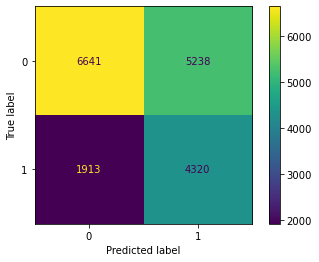

In [38]:
print_cv_scores(lr_pipe4, X_train_clean, y_train)
plot_confusion_matrix(lr_pipe4, X_train_clean, y_train)

### Decision Tree classifier
#### With SMOTE

In [39]:
# dt1_pipe = imbpipe(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('sm', SMOTE(random_state=123)),
#     ('dt', DecisionTreeClassifier(random_state=123))
# ])

# dt_param_grid = {
#     'dt__criterion': ['gini', 'entropy'],
#     'dt__max_depth': [None, 2, 3, 4, 5, 6],
#     'dt__min_samples_split': [2, 5, 10],
#     'dt__min_samples_leaf': [1, 2, 3, 4, 5, 6]
# }

# dt_gridsearch = GridSearchCV(estimator=dt1_pipe, 
#                           param_grid=dt_param_grid, 
#                           scoring='recall', 
#                           cv=5)

# # Fit the training data
# dt_gridsearch.fit(X_train_clean, y_train)

# with open("models/dt_gridsearch.pkl", "wb") as f:
#     joblib.dump(dt_gridsearch, f)

In [40]:
# Reading the pickle file
with open('models/dt_gridsearch.pkl', 'rb') as f:
    dt_gridsearch = joblib.load(f)

In [41]:
print(dt_gridsearch.best_params_)

{'dt__criterion': 'gini', 'dt__max_depth': 2, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}


In [42]:
# # Optimized Decision Tree
# dt2_pipe = imbpipe(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('sm', SMOTE(random_state=123)),
#     ('dt', DecisionTreeClassifier(criterion='gini',
#                                   max_depth = 2,
#                                   min_samples_leaf = 1,
#                                   min_samples_split= 2,
#                                   random_state=123))
# ])

# dt2_pipe.fit(X_train_clean, y_train)

# with open("models/dt2_pipe.pkl", "wb") as f:
#     joblib.dump(dt2_pipe, f)

In [43]:
# Reading the pickle file
with open('models/dt2_pipe.pkl', 'rb') as f:
    dt2_pipe = joblib.load(f)

[0.53695907 0.53640693 0.53512767 0.53533471 0.53657695]
Training Accuracy 0.5360810678537169
##############
[0.53298372 0.53105161 0.54030922 0.53533959 0.53451132]
Cross_Val Accuracy 0.5348390924721238
##############
Training Macro Precision: 0.5977079587870111
Cross_Val Macro Precision: 0.5963900758932918
##############
Training Macro Recall: 0.5965832867469253
Cross_Val Macro Recall: 0.5952452108492757
##############
Training Macro F1: 0.5360499058243883
Cross_Val Macro F1: 0.5347910546430992


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


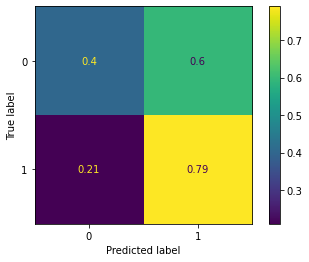

In [44]:
print_cv_scores(dt2_pipe, X_train_clean, y_train)
plot_confusion_matrix(dt2_pipe, X_train_clean, y_train, normalize='true')

#### Decision Tree Without SMOTE

In [45]:
# dt3_pipe = Pipeline(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('dt', DecisionTreeClassifier(random_state=123))
# ])

# dt3_gridsearch = GridSearchCV(estimator=dt3_pipe, 
#                           param_grid=dt_param_grid, 
#                           scoring='recall', 
#                           cv=5)

# # Fit the training data
# dt3_gridsearch.fit(X_train_clean, y_train)

# with open("models/dt3_gridsearch.pkl", "wb") as f:
#     joblib.dump(dt3_gridsearch, f)

In [46]:
# Reading the pickle file
with open('models/dt3_gridsearch.pkl', 'rb') as f:
    dt3_gridsearch = joblib.load(f)

In [47]:
print(dt3_gridsearch.best_params_)

{'dt__criterion': 'entropy', 'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 10}


In [85]:
# # Optimized Decision Tree without SMOTE

# dt4_pipe = Pipeline(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('dt', DecisionTreeClassifier(criterion='entropy',
#                                   max_depth = None,
#                                   min_samples_leaf = 1,
#                                   min_samples_split= 10,
#                                   random_state=123))
# ])

# dt4_pipe.fit(X_train_clean, y_train)

# with open("models/dt4_pipe.pkl", "wb") as f:
#     joblib.dump(dt4_pipe, f)

In [49]:
# Reading the pickle file
with open('models/dt4_pipe.pkl', 'rb') as f:
    dt4_pipe = joblib.load(f)

[0.71889019 0.72061564 0.72008282 0.71725328 0.71656315]
Training Accuracy 0.7186810145732507
##############
[0.64890974 0.64366547 0.63942573 0.65378244 0.65102154]
Cross_Val Accuracy 0.6473609842510265
##############
Training Macro Precision: 0.6982134380652912
Cross_Val Macro Precision: 0.5835317227677903
##############
Training Macro Recall: 0.6353532906865491
Cross_Val Macro Recall: 0.5580276250553798
##############
Training Macro F1: 0.640823586395034
Cross_Val Macro F1: 0.5524159038763503


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


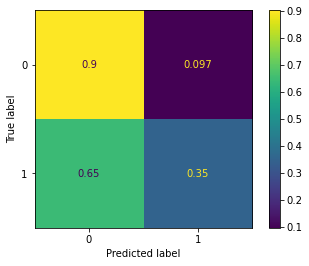

In [86]:
print_cv_scores(dt4_pipe, X_train_clean, y_train)
plot_confusion_matrix(dt4_pipe, X_train_clean, y_train, normalize='true')

### Random Forest classifier
#### With SMOTE

In [51]:
# # Searching for the best RF hyperparameters
# rf_grid = [{'RF__max_depth': [4, 5, 6], 
#          'RF__min_samples_split': [2, 5, 10], 
#          'RF__min_samples_leaf': [1, 3, 5]}]

# rf1_pipe = imbpipe(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('sm', SMOTE(random_state=123)),
#     ('RF', RandomForestClassifier(random_state=123))
# ])

# rf_gridsearch = GridSearchCV(estimator=rf1_pipe, 
#                           param_grid=rf_grid, 
#                           scoring='recall', 
#                           cv=5)

# # Fit the training data
# rf_gridsearch.fit(X_train_clean, y_train)

# with open("models/rf_gridsearch.pkl", "wb") as f:
#     joblib.dump(rf_gridsearch, f)

In [52]:
# Reading the pickle file
with open('models/rf_gridsearch.pkl', 'rb') as f:
    rf_gridsearch = joblib.load(f)

In [53]:
# Print the recall on test set and best params
print(rf_gridsearch.best_params_)

{'RF__max_depth': 4, 'RF__min_samples_leaf': 3, 'RF__min_samples_split': 2}


In [87]:
# # Optimized RT Classifier

# rf2_pipe = imbpipe(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('sm', SMOTE(random_state=123)),
#     ('dt',  RandomForestClassifier(max_depth = 4,
#                                    min_samples_leaf = 3,
#                                    min_samples_split = 2,
#                                    random_state=123))
# ])

# rf2_pipe.fit(X_train_clean, y_train)

# with open("models/rf2_pipe.pkl", "wb") as f:
#     joblib.dump(rf2_pipe, f)

In [55]:
# Reading the pickle file
with open('models/rf2_pipe.pkl', 'rb') as f:
    rf2_pipe = joblib.load(f)

[0.57774864 0.57740355 0.57529331 0.57467219 0.57253278]
Training Accuracy 0.5755300918175903
##############
[0.56748551 0.56996964 0.57620099 0.57288791 0.57702927]
Cross_Val Accuracy 0.5727146628852751
##############
Training Macro Precision: 0.608512966101162
Cross_Val Macro Precision: 0.605354444827863
##############
Training Macro Recall: 0.615962500261368
Cross_Val Macro Recall: 0.6126446083420765
##############
Training Macro F1: 0.5738603505351747
Cross_Val Macro F1: 0.5710083276505244


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


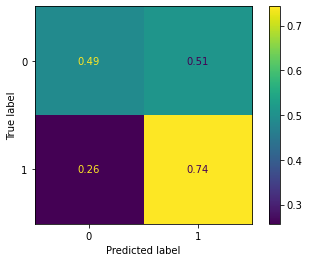

In [88]:
print_cv_scores(rf2_pipe, X_train_clean, y_train)
plot_confusion_matrix(rf2_pipe, X_train_clean, y_train, normalize='true')

#### Random Forest without SMOTE

In [57]:
# # Optimized RT Classifier
# # Searching for the best RF hyperparameters

# rf3_pipe = Pipeline(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('RF', RandomForestClassifier(random_state=123))
# ])

# rf3_gridsearch = GridSearchCV(estimator=rf3_pipe, 
#                           param_grid=rf_grid, 
#                           scoring='recall', 
#                           cv=5)

# # Fit the training data
# rf3_gridsearch.fit(X_train_clean, y_train)

# with open("models/rf3_gridsearch.pkl", "wb") as f:
#     joblib.dump(rf3_gridsearch, f)

In [58]:
# Reading the pickle file
with open('models/rf3_gridsearch.pkl', 'rb') as f:
    rf3_gridsearch = joblib.load(f)

In [59]:
# Print the recall on test set and best params
print(rf3_gridsearch.best_params_)

{'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}


In [60]:
# rf4_pipe = Pipeline(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('dt',  RandomForestClassifier(max_depth = 6,
#                                    min_samples_leaf = 1,
#                                    min_samples_split = 2,
#                                    random_state=123))
# ])

# rf4_pipe.fit(X_train_clean, y_train)

# with open("models/rf4_pipe.pkl", "wb") as f:
#     joblib.dump(rf4_pipe, f)

In [61]:
# Reading the pickle file
with open('models/rf4_pipe.pkl', 'rb') as f:
    rf4_pipe = joblib.load(f)

[0.66339982 0.66277866 0.66438923 0.66383713 0.66445825]
Training Accuracy 0.6637726180604586
##############
[0.66133039 0.65829423 0.66178907 0.65902816 0.65930425]
Cross_Val Accuracy 0.6599492200651309
##############
Training Macro Precision: 0.7150469305542985
Cross_Val Macro Precision: 0.6495711667127974
##############
Training Macro Recall: 0.5139121864122969
Cross_Val Macro Recall: 0.5095964363393563
##############
Training Macro F1: 0.4293205850209373
Cross_Val Macro F1: 0.4225392001291999


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


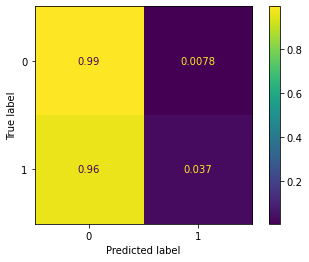

In [62]:
print_cv_scores(rf4_pipe, X_train_clean, y_train)
plot_confusion_matrix(rf4_pipe, X_train_clean, y_train, normalize='true')

### XGBoost classifier
#### With SMOTE

In [63]:
# # Searching for the best hyperparameters
# xgb_grid = {
#     'xg__learning_rate': [0.1, 0.2],
#     'xg__max_depth': [6],
#     'xg__min_child_weight': [1, 2],
#     'xg__subsample': [0.5, 0.7],
#     'xg__n_estimators': [100],
# }

# xgb1_pipe = imbpipe(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('sm', SMOTE(random_state=123)),
#     ('xg', XGBClassifier(random_state=123))
# ])

# xgb_gridsearch = GridSearchCV(estimator=xgb1_pipe, 
#                           param_grid=xgb_grid, 
#                           scoring='recall', 
#                           cv=5)

# # Fit the training data
# xgb_gridsearch.fit(X_train_clean, y_train)

# with open("models/xgb_gridsearch.pkl", "wb") as f:
#     joblib.dump(xgb_gridsearch, f)

In [64]:
# Reading the pickle file
with open('models/xgb_gridsearch.pkl', 'rb') as f:
    xgb_gridsearch = joblib.load(f)

In [65]:
# Print the recall on test set and best params
print(xgb_gridsearch.best_params_)

{'xg__learning_rate': 0.1, 'xg__max_depth': 6, 'xg__min_child_weight': 2, 'xg__n_estimators': 100, 'xg__subsample': 0.7}


In [66]:
# # Optimized XGBoost Classifier
# xgb2_pipe = imbpipe(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('sm', SMOTE(random_state=123)),
#     ('xg', XGBClassifier(learning_rate = 0.1,
#                          max_depth = 6,
#                          min_child_weight = 2,
#                          n_estimators = 100,
#                          subsample = 0.7,
#                          random_state=123))
# ])

# xgb2_pipe.fit(X_train_clean, y_train)

# with open("models/xgb2_pipe.pkl", "wb") as f:
#     joblib.dump(xgb2_pipe, f)

In [67]:
# Reading the pickle file
with open('models/xgb2_pipe.pkl', 'rb') as f:
    xgb2_pipe = joblib.load(f)

[0.64448892 0.65194285 0.65182885 0.64189096 0.64382333]
Training Accuracy 0.6467949818050494
##############
[0.61689208 0.61772012 0.61954721 0.62755384 0.63638874]
Cross_Val Accuracy 0.6236203968967512
##############
Training Macro Precision: 0.6322933409033711
Cross_Val Macro Precision: 0.6082536990475912
##############
Training Macro Recall: 0.6449560590997712
Cross_Val Macro Recall: 0.6185122898179387
##############
Training Macro F1: 0.6309764332518663
Cross_Val Macro F1: 0.6063651340193283


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


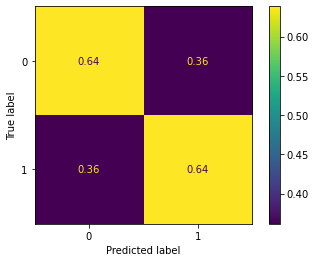

In [68]:
print_cv_scores(xgb2_pipe, X_train_clean, y_train)
plot_confusion_matrix(xgb2_pipe, X_train_clean, y_train, normalize='true')

#### XGBoost Classifier without SMOTE

In [69]:
# xgb3_pipe = Pipeline(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('xg', XGBClassifier(random_state=123))
# ])

# xgb3_gridsearch = GridSearchCV(estimator=xgb3_pipe, 
#                           param_grid=xgb_grid, 
#                           scoring='recall', 
#                           cv=5)

# # Fit the training data
# xgb3_gridsearch.fit(X_train_clean, y_train)

# with open("models/xgb3_gridsearch.pkl", "wb") as f:
#     joblib.dump(xgb3_gridsearch, f)

In [70]:
# Reading the pickle file
with open('models/xgb3_gridsearch.pkl', 'rb') as f:
    xgb3_gridsearch = joblib.load(f)

In [71]:
# Print the recall on test set and best params
print(xgb3_gridsearch.best_params_)

{'xg__learning_rate': 0.2, 'xg__max_depth': 6, 'xg__min_child_weight': 2, 'xg__n_estimators': 100, 'xg__subsample': 0.5}


In [89]:
# xgb4_pipe = Pipeline(steps=[
#     ("ohe", OneHotEncoder(drop='first', sparse=False)),
#     ('xg', XGBClassifier(learning_rate = 0.2,
#                          max_depth = 6,
#                          min_child_weight = 2,
#                          n_estimators = 100,
#                          subsample = 0.5,
#                          random_state=123))
# ])

# xgb4_pipe.fit(X_train_clean, y_train)

# with open("models/xgb4_pipe.pkl", "wb") as f:
#     joblib.dump(xgb4_pipe, f)

In [73]:
# Reading the pickle file
with open('models/xgb4_pipe.pkl', 'rb') as f:
    xgb4_pipe = joblib.load(f)

[0.69252536 0.69542411 0.69468599 0.6899931  0.69254658]
Training Accuracy 0.6930350303585772
##############
[0.66712669 0.64863373 0.65599117 0.66758697 0.65295417]
Cross_Val Accuracy 0.6584585444274135
##############
Training Macro Precision: 0.6579541742378651
Cross_Val Macro Precision: 0.5997563083398594
##############
Training Macro Recall: 0.6035627536862004
Cross_Val Macro Recall: 0.5654987120220929
##############
Training Macro F1: 0.6034333837391913
Cross_Val Macro F1: 0.5592150319081652


/Users/robertharrow/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


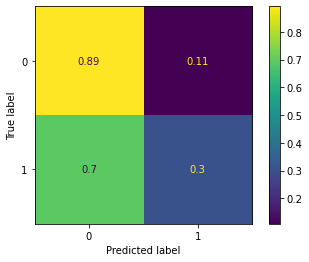

In [90]:
print_cv_scores(xgb4_pipe, X_train_clean, y_train)
plot_confusion_matrix(xgb4_pipe, X_train_clean, y_train, normalize='true')

In [75]:
# orig_feature_names = list(xgb2_pipe['ohe'].get_feature_names())
# xgb2_pipe['xg'].get_booster().feature_names = orig_feature_names
# xgb2_pipe['xg'].get_booster().get_fscore()

In [76]:
# # Code from https://stackoverflow.com/questions/40081888/xgboost-plot-importance-figure-size
# def my_plot_importance(booster, figsize, **kwargs): 
#     from matplotlib import pyplot as plt
#     from xgboost import plot_importance
#     fig, ax = plt.subplots(1,1,figsize=figsize)
#     return plot_importance(booster=booster, ax=ax, **kwargs)

In [77]:
# my_plot_importance(xgb2_pipe['xg'],(10,20))

### Investingating the Best Performing Model
Out of all the different models and hyper-parameters we tried above, we got the best performence using Logistic Regression. Let's take a look at the coefficients driving that model.

In [78]:
coefs = list(lr_pipe4['lr'].coef_[0])
features = list(lr_pipe4['ohe'].get_feature_names_out())
zipped = list(zip(features,coefs))
results = pd.DataFrame(zipped, columns=['Feature','Coeffficient'])

In [79]:
results.sort_values(by='Coeffficient', ascending=False)

,Feature,Coeffficient
20,Sex_Male,0.358081
23,Offense Type_Other,0.273606
21,Offense Classification_misdemeanor,0.253392
22,Offense Classification_other,0.243357
3,Main Supervising District_5JD,0.186700
2,Main Supervising District_4JD,0.152320
24,Offense Type_Property,0.068812
19,Age At Release _Under 25,0.032672
0,Main Supervising District_2JD,0.015154
1,Main Supervising District_3JD,0.002153


## Exploratory Data Analysis

In [80]:
clean_data = pd.concat([y_train, X_train_clean], axis=1)

In [81]:
clean_data.columns

Index(['Return to Prison', 'Main Supervising District', 'Release Type',
       'Race - Ethnicity', 'Age At Release ', 'Sex', 'Offense Classification',
       'Offense Type', 'Target Population'],
      dtype='object')

In [101]:
clean_data['Return to Prison'].value_counts(normalize=True)

0    0.655864
1    0.344136
Name: Return to Prison, dtype: float64

In [82]:
recidvism_by_sex = pd.crosstab(clean_data.Sex, clean_data['Return to Prison'], normalize='index')
recidvism_by_sex

Return to Prison,0,1
Sex,,
Female,0.696995,0.303005
Male,0.649593,0.350407


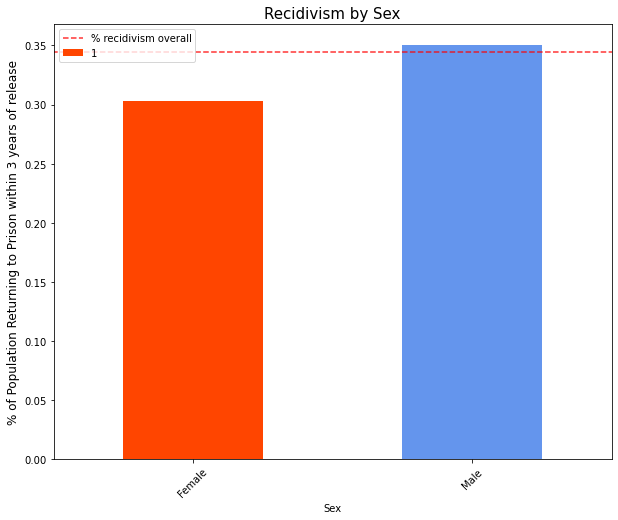

In [105]:
# Graph the crosstab table
fig, ax = plt.subplots(figsize=(10, 8))
recidvism_by_sex[1].plot.bar(ax=ax, color=('orangered', 'cornflowerblue'))
plt.title('Recidivism by Sex', size=15)
plt.ylabel('% of Population Returning to Prison within 3 years of release', size=12)

# Adding line to emphasize average recidivisim rate in population
plt.hlines(y=0.344136, xmin=-50, xmax=100, alpha=0.8, color='red', ls='--', label='% recidivism overall')


plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [93]:
recidvism_by_off_type = pd.crosstab(clean_data['Offense Type'],
                               clean_data['Return to Prison'],
                               normalize='index')

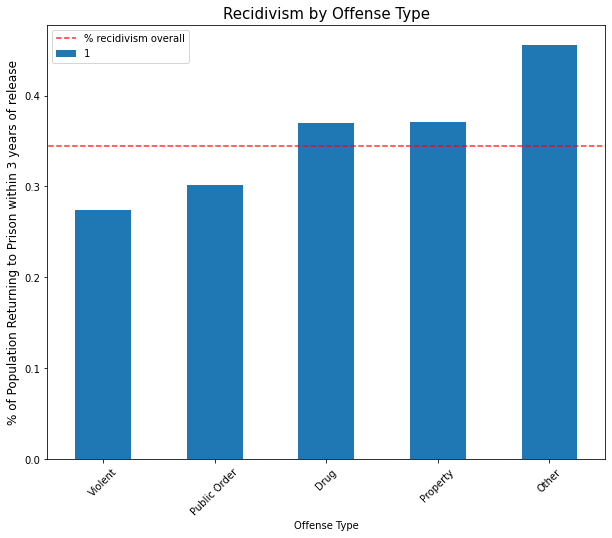

In [104]:
# Graph the crosstab table
fig, ax = plt.subplots(figsize=(10, 8))
recidvism_by_off_type[1].sort_values().plot.bar(ax=ax)
plt.title('Recidivism by Offense Type', size=15)
plt.ylabel('% of Population Returning to Prison within 3 years of release', size=12)

# Adding line to emphasize average recidivisim rate in population
plt.hlines(y=0.344136, xmin=-50, xmax=100, alpha=0.8, color='red', ls='--', label='% recidivism overall')

plt.legend()
plt.xticks(rotation = 45)
plt.show()

In [106]:
recidvism_by_off_class = pd.crosstab(clean_data['Offense Classification'],
                               clean_data['Return to Prison'],
                               normalize='index')

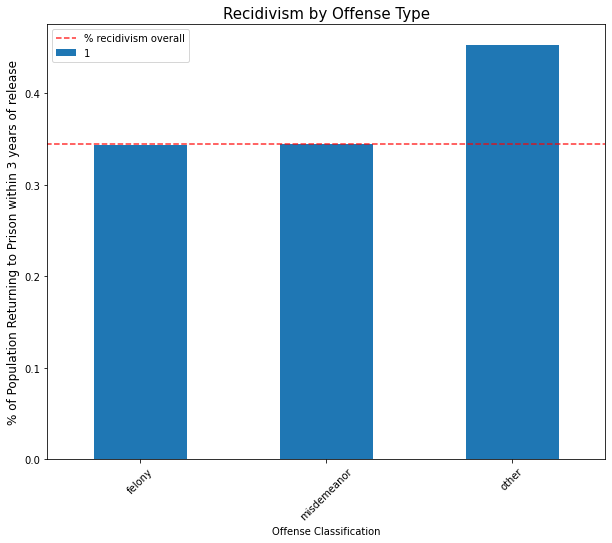

In [107]:
# Graph the crosstab table
fig, ax = plt.subplots(figsize=(10, 8))
recidvism_by_off_class[1].sort_values().plot.bar(ax=ax)
plt.title('Recidivism by Offense Type', size=15)
plt.ylabel('% of Population Returning to Prison within 3 years of release', size=12)

# Adding line to emphasize average recidivisim rate in population
plt.hlines(y=0.344136, xmin=-50, xmax=100, alpha=0.8, color='red', ls='--', label='% recidivism overall')

plt.legend()
plt.xticks(rotation = 45)
plt.show()